# L16: Multiclass Logistic Regression

## Goals of this lecture

- Learning what to do if we have more than two classes
- Learning about multi-layer perceptrons

## What to do if we have more than two classes?

Imagine we are given a dataset ${\cal D} = \{(x^{(i)}, y^{(i)}\}$ where $y^{(i)}\in\{0, 1, \dots, C-1\}$. How can we learn a classifier to deal with this?

- learn $C$ **one vs rest** classifiers; Problem:

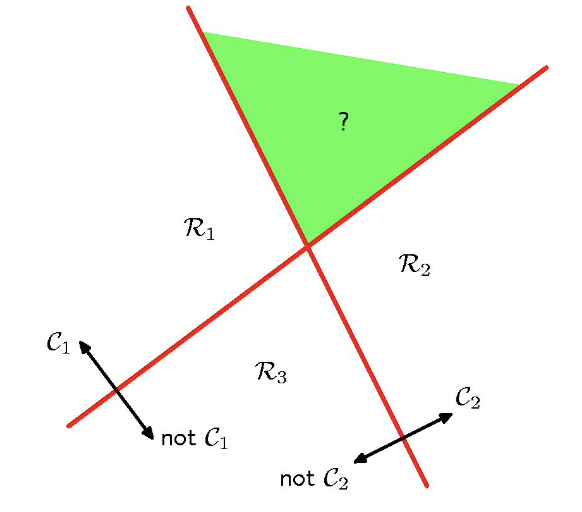

- learn $C(C-1)/2$ two-way classifiers for each possible pair of classes; Problem:

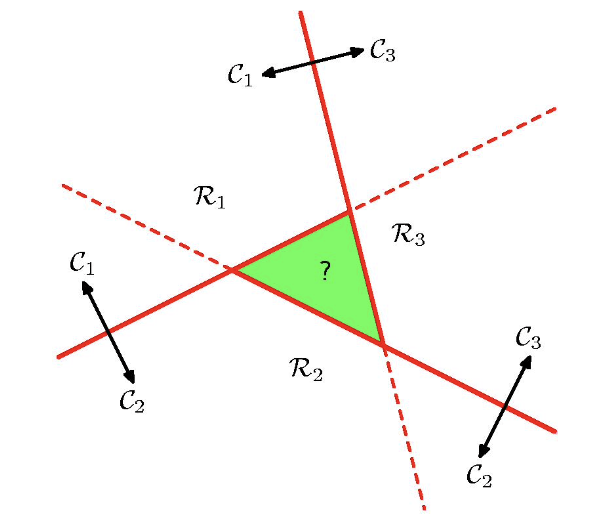

Both options aren't ideal. Is there something better?

How about we formulate this with probabilities again but change the sigmoid function to something else. Instead of saying $$p(Y=y|x) = \frac{1}{1+\exp(-yw^Tx)} \quad \text{for} y\in\{-1,1\}$$
we use something else.

What do our probabilities have to satisfy?

- non-negativity: $p(Y=y|x) \geq 0$ $\forall y\in\{0, \dots, C-1\}$
- sum to one: $\sum_{y\in\{0, \dots, C-1\}} p(Y=y|x) = 1$

Which function could satisfy this?

$$p(Y=y|x) = \frac{\exp(w_y^Tx)}{\sum_{\hat y\in\{0, \dots, C-1\}} \exp(w_{\hat y}^Tx)}$$

- Note: every class has its own weight vector $w_y$

Let's train a model using this probabilistic model and let's study the result to see whether this makes sense

Example data:

In [56]:
import torch
x0 = torch.cat([torch.randn((100,))-1,torch.randn((100,))+1,torch.randn((100,))+3],dim=0)
y = torch.cat([torch.zeros((100,),dtype=torch.int8),torch.ones((100,),dtype=torch.int8),2*torch.ones((100,),dtype=torch.int8)],dim=0)

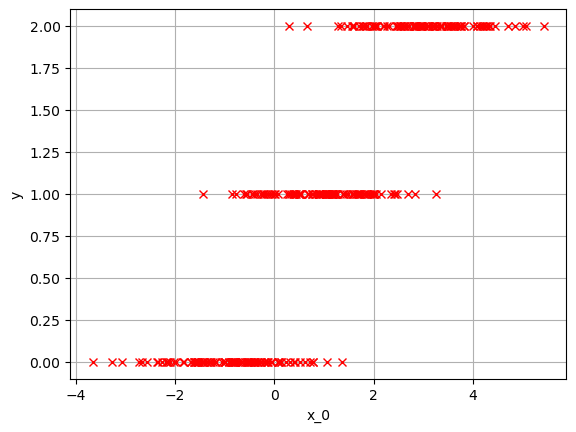

In [57]:
import matplotlib.pyplot as plt
plt.plot(x0,y,'rx')
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('y')
plt.show()

How did we train a model again?

Maximum-likelihood or minimizing the negative log-likelihood:

$$\min_w \sum_{(x^{(i)},y^{(i)})\in{\cal D}} -\log p(y|x)$$

Let's plug our probability model in there and see what happens:

$$\min_w \sum_{(x^{(i)},y^{(i)})\in{\cal D}} \left(- w_{y^{(i)}}^Tx + \log\sum_{\hat y\in\{0, \dots, C-1\}} \exp(w_{\hat y}^Tx)\right)$$

Gradient of the objective (homework). We use pytorch so why bother to compute it manually.

How to efficiently implement this objective function? Let's put the weight vectors for each class into a matrix

$$W = \left[\begin{array}{ccc}\vdots&&\vdots\\w_0&\dots&w_{C-1}\\\vdots&&\vdots\end{array}\right]\in\mathbb{R}^{D\times C}$$

In [58]:
W0 = torch.randn((2,3))

In [59]:
X = torch.cat([x0.unsqueeze(0), torch.ones_like(x0).unsqueeze(0)],dim=0)
def objfun(X,y,W):
    #res1 = (W[:,y.to(torch.long)]*X).sum(dim=0)
    logits = W.t()@X
    firstterm = -torch.gather(logits,dim=0,index=y.view(1,-1).to(torch.int64))
    secondterm = torch.logsumexp(logits,dim=0,keepdim=True)
    return torch.mean(firstterm+secondterm)
objfun(X,y,W0)

tensor(1.5312)

In [60]:
w = W0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0)
for iter in range(numIter):
    optimizer.zero_grad()
    f = objfun(X,y,w)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

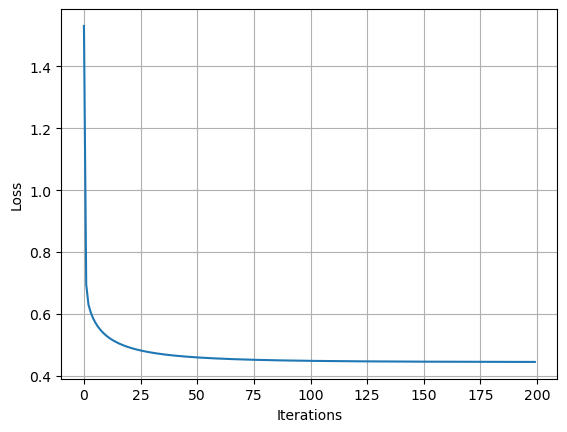

In [61]:
plt.plot(range(numIter),funs)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

What's our $W$ matrix now?

In [62]:
print(w)

tensor([[-1.8273,  0.3415,  2.5912],
        [ 0.6225,  0.5683, -3.7836]], requires_grad=True)


How do we check that this makes sense?

Note that we can't plot the loss function in parameter space anymore. Why?

We have 6 parameters, i.e., 6-dimensional space. Hard to plot.

But we can plot the probabilities: $$p(Y=y|x) = \frac{\exp(w_y^Tx)}{\sum_{\hat y\in\{0, \dots, C-1\}} \exp(w_{\hat y}^Tx)}$$

In [63]:
xaxis = torch.linspace(-5,5,100)
Xxaxis = torch.cat([xaxis.unsqueeze(0),torch.ones_like(xaxis).unsqueeze(0)],dim=0)
logits = w.detach().t()@Xxaxis
probs = torch.nn.functional.softmax(logits,dim=0)
print(probs.shape)

torch.Size([3, 100])


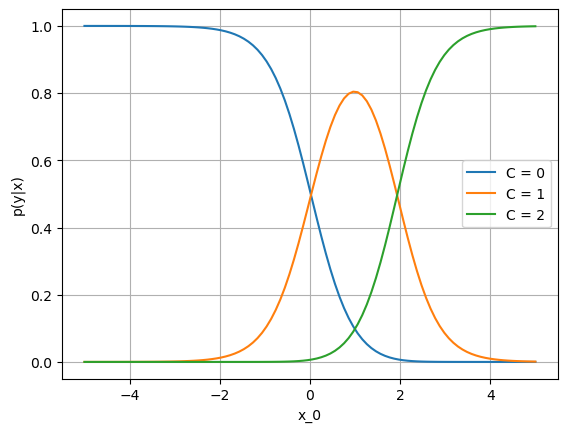

In [64]:
plt.plot(xaxis,probs.t())
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('p(y|x)')
plt.legend(['C = 0','C = 1','C = 2'])
plt.show()

Seems reasonable.

What are these logits?

In [65]:
print(logits.shape)

torch.Size([3, 100])


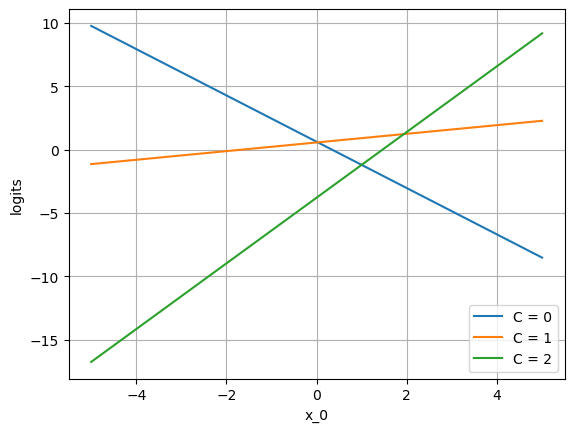

In [66]:
plt.plot(xaxis,logits.t())
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('logits')
plt.legend(['C = 0','C = 1','C = 2'])
plt.show()

Can we avoid some of the code above? I.e., can we compress this more and use more pytorch code?

Pytorch's ```torch.CrossEntropyLoss``` (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) looks very similar to what we need:

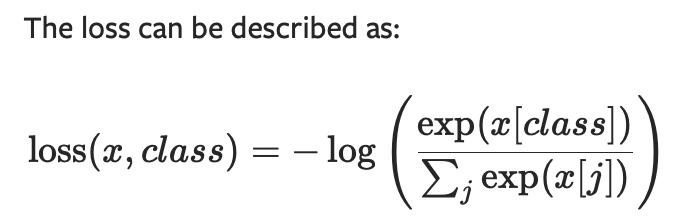

How can we use this one? What do we need?

In [67]:
def LinearNetFun(X,W):
    logits = W.t()@X
    return logits.t()

In [68]:
w = W0.clone()
w.requires_grad = True
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD([w],lr=alpha,momentum=0,dampening=0,weight_decay=0)
loss = torch.nn.CrossEntropyLoss()
ylong = y.to(torch.long)
for iter in range(numIter):
    optimizer.zero_grad()
    f = loss(LinearNetFun(X,w),ylong)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

In [69]:
print(w)

tensor([[-1.8273,  0.3415,  2.5912],
        [ 0.6225,  0.5683, -3.7836]], requires_grad=True)


Same result as before. Very nice. Looks like we used ```torch.CrossEntropyLoss``` the right way.

Weights shouldn't be defined anywhere in the code. Let's clean this up a little more.

Recall the plotting of composite functions from Lecture 4. Let's use the same syntax

In [70]:
class OurNet(torch.nn.Module):
    def __init__(self):
        super(OurNet,self).__init__()
        self.fc1 = torch.nn.Linear(2,3,bias=False)
    def forward(self,x):
        return self.fc1(x.t())
net1 = OurNet()

In [71]:
net1.fc1.weight.data = W0.t().data.clone()

In [ ]:
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD(net1.parameters(),lr=alpha,momentum=0,dampening=0,weight_decay=0)

loss = torch.nn.CrossEntropyLoss()
ylong = y.to(torch.long)
for iter in range(numIter):
    optimizer.zero_grad()
    f = loss(net1(X),ylong)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

<generator object Module.parameters at 0x7fb352daf270>


In [73]:
print(net1.fc1.weight)

Parameter containing:
tensor([[-1.8273,  0.6225],
        [ 0.3415,  0.5683],
        [ 2.5912, -3.7836]], requires_grad=True)


Same result again. Very nice, this is starting to look clean now.

But wait, why do we manually append our data with ones? Isn't that wasteful? Can we avoid this?

In [74]:
class OurNet2(torch.nn.Module):
    def __init__(self):
        super(OurNet2,self).__init__()
        self.fc1 = torch.nn.Linear(1,3,bias=True)
    def forward(self,x):
        return self.fc1(x)
net2 = OurNet2()

In [75]:
net2.fc1.weight.data = W0[0,:].view(-1,1).data.clone()
net2.fc1.bias.data = W0[1,:].view(-1).data.clone()

In [76]:
alpha = 1.0
numIter = 200
funs = torch.zeros((numIter,1))
optimizer = torch.optim.SGD(net2.parameters(),lr=alpha,momentum=0,dampening=0,weight_decay=0)
loss = torch.nn.CrossEntropyLoss()
ylong = y.to(torch.long)
for iter in range(numIter):
    optimizer.zero_grad()
    f = loss(net2(x0.view(-1,1)),ylong)
    f.backward()
    optimizer.step()
    funs[iter] = f.item()

In [77]:
print(net2.fc1.weight)
print(net2.fc1.bias)

Parameter containing:
tensor([[-1.8273],
        [ 0.3415],
        [ 2.5912]], requires_grad=True)
Parameter containing:
tensor([ 0.6225,  0.5683, -3.7836], requires_grad=True)


Exactly the same result again. Nice. Looks like we understand this now.

How much do we have to implement?

Basically only the forward pass in our "deep" network. Everything else is mostly copy paste and use of existing code. This means we can get really creative with deep networks now. Let's try to use more complicated functions and let's see what happens. Before doing this let's recall our training loss and the probabilities.

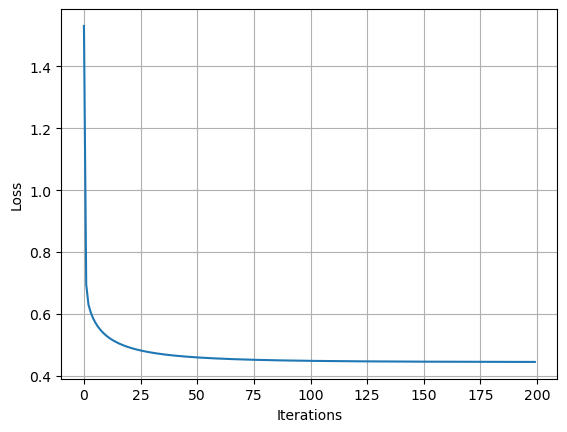

In [78]:
plt.plot(range(numIter),funs)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

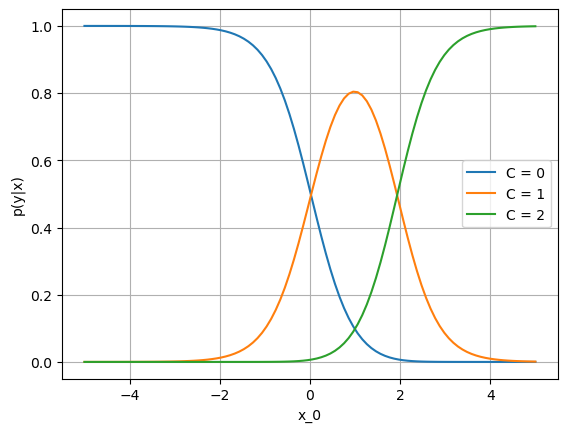

In [79]:
plt.plot(xaxis,torch.nn.functional.softmax(net2(xaxis.view(-1,1)),dim=1).detach())
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('p(y|x)')
plt.legend(['C = 0','C = 1','C = 2'])
plt.show()

In [80]:
class OurNet3(torch.nn.Module):
    def __init__(self):
        super(OurNet3,self).__init__()
        self.fc1 = torch.nn.Linear(1,64)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.fc2 = torch.nn.Linear(64,128)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.fc3 = torch.nn.Linear(128,3)
    def forward(self,x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)
net3 = OurNet3()

In [81]:
def TrainingLoop(Xdata, ydata, net, alpha=1.0):
    numIter = 200
    funs = torch.zeros((numIter,1))
    optimizer = torch.optim.SGD(net.parameters(),lr=alpha,momentum=0,dampening=0,weight_decay=0)
    loss = torch.nn.CrossEntropyLoss()
    for iter in range(numIter):
        optimizer.zero_grad()
        f = loss(net(Xdata),ydata)
        f.backward()
        optimizer.step()
        funs[iter] = f.item()
    return funs

In [82]:
funs3 = TrainingLoop(x0.view(-1,1),y.to(torch.long),net3)

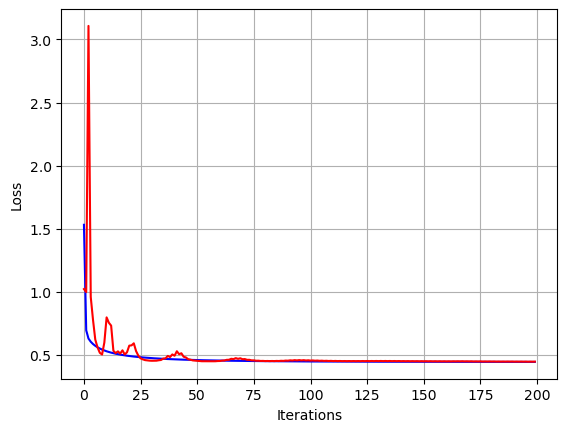

In [83]:
plt.plot(range(numIter),funs,'-b')
plt.plot(range(numIter),funs3,'-r')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

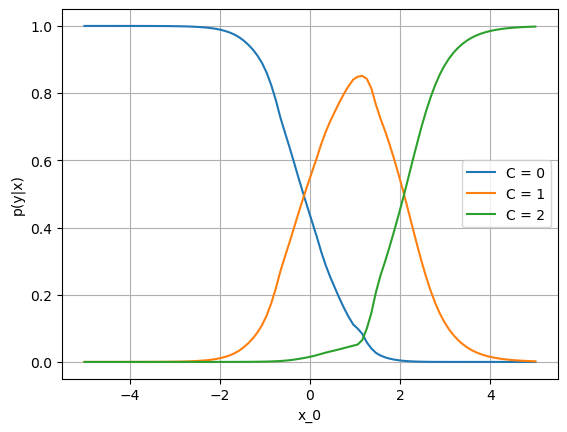

In [84]:
plt.plot(xaxis,torch.nn.functional.softmax(net3(xaxis.view(-1,1)),dim=1).detach())
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('p(y|x)')
plt.legend(['C = 0','C = 1','C = 2'])
plt.show()

How about an even deeper net, e.g., a **multi-layer perceptron (MLP)**?

In [85]:
class OurNet4(torch.nn.Module):
    def __init__(self):
        super(OurNet4,self).__init__()
        self.fc1 = torch.nn.Linear(1,128)
        self.relu1 = torch.nn.ReLU(inplace=True)
        self.fc2 = torch.nn.Linear(128,256)
        self.relu2 = torch.nn.ReLU(inplace=True)
        self.fc3 = torch.nn.Linear(256,512)
        self.relu3 = torch.nn.ReLU(inplace=True)
        self.fc4 = torch.nn.Linear(512,1024)
        self.relu4 = torch.nn.ReLU(inplace=True)
        self.fc5 = torch.nn.Linear(1024,256)
        self.relu5 = torch.nn.ReLU(inplace=True)
        self.fc6 = torch.nn.Linear(256,3)
    def forward(self,x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.relu5(self.fc5(x))
        return self.fc6(x)
net4 = OurNet4()

How many parameters does this deep net have?

In [86]:
num_weights = 1*128+128*256+256*512+512*1024+1024*256+256*3
num_biases = 128+256+512+1024+256+3
print(num_weights)
print(num_biases)

951168
2179


In [87]:
funs4 = TrainingLoop(x0.view(-1,1),y.to(torch.long),net4,0.1)

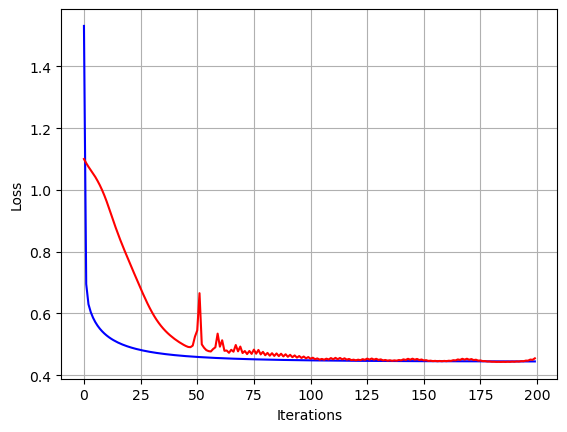

In [88]:
plt.plot(range(numIter),funs,'-b')
plt.plot(range(numIter),funs4,'-r')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

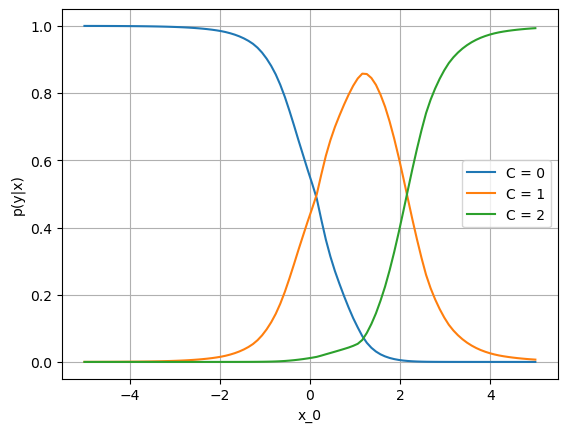

In [89]:
plt.plot(xaxis,torch.nn.functional.softmax(net4(xaxis.view(-1,1)),dim=1).detach())
plt.grid(True)
plt.xlabel('x_0')
plt.ylabel('p(y|x)')
plt.legend(['C = 0','C = 1','C = 2'])
plt.show()

Summary (what are the main components that we should worry about):

- Deep net (Linear layers, Rectified linear units, multi-layer perceptron (MLP))
- Loss (CrossEntropyLoss)
- Optimizer (Stochastic Gradient Descent - for us currently gradient descent)

There are many more losses (https://pytorch.org/docs/stable/nn.html#loss-functions):

- CrossEntropyLoss
- NLLLoss (when combined with ```torch.nn.LogSoftmax``` can be used to create CrossEntropyLoss)
- BCEWithLogitsLoss (for 2-class classification problems)
- BCELoss (for 2-class classification problems)
- ...


There are many more optimizers (https://pytorch.org/docs/stable/optim.html):

- Stochastic gradient descent (SGD)
- Adam
- RMSprop
- LBFGS
- ...